**Uploading **the** Dataset**

In [1]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_excel(filename)

print(df.head())
print(df.info())

Saving 65 Years of Weather Data Bangladesh (1948 - 2013).csv.xlsx to 65 Years of Weather Data Bangladesh (1948 - 2013).csv.xlsx
  Station Names  YEAR  Month  Max Temp  Min Temp  Rainfall  Relative Humidity  \
0       Barisal  1949      1      29.4      12.3       0.0               68.0   
1       Barisal  1950      1      30.0      14.1       0.0               77.0   
2       Barisal  1951      1      28.2      12.3       0.0               77.0   
3       Barisal  1952      1      26.6      12.3       2.0               77.0   
4       Barisal  1953      1      30.0      13.3      10.0               75.0   

   Wind Speed  Cloud Coverage  Bright Sunshine  Station Number     X_COR  \
0    0.453704             0.6         7.831915           41950  536809.8   
1    0.453704             0.8         7.831915           41950  536809.8   
2    0.453704             0.6         7.831915           41950  536809.8   
3    0.453704             1.0         7.831915           41950  536809.8   
4    

**Exploratory Data Analysis (EDA)**

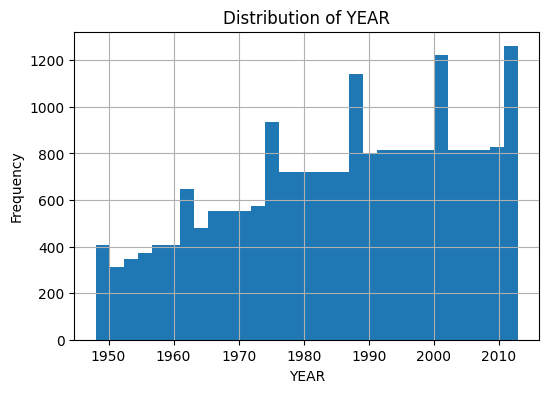

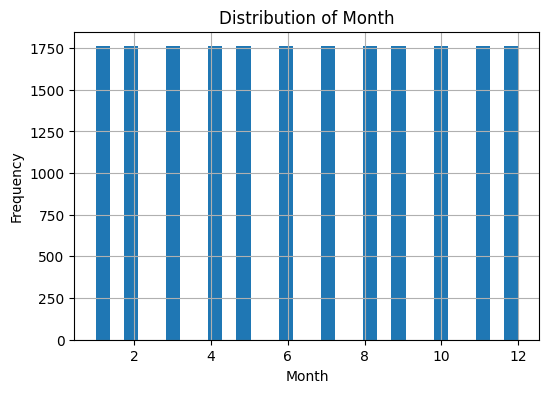

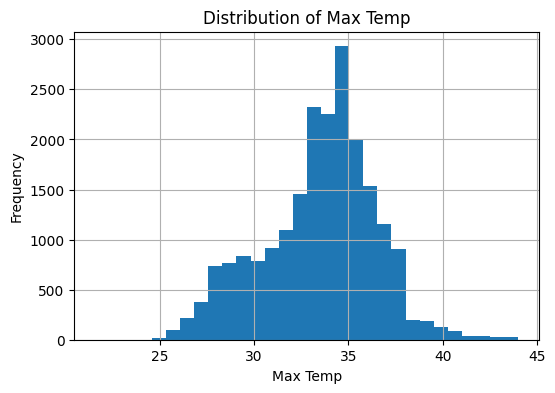

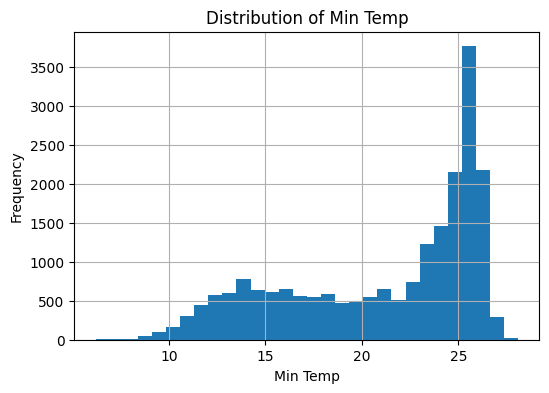

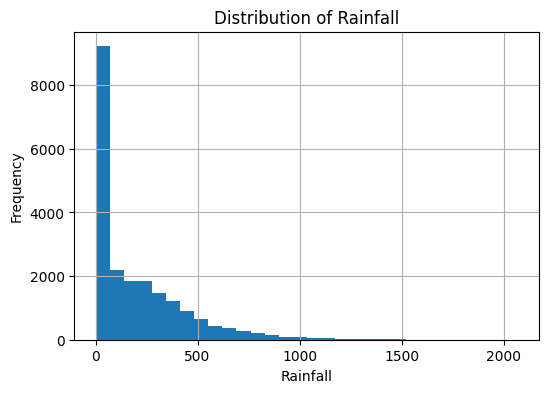

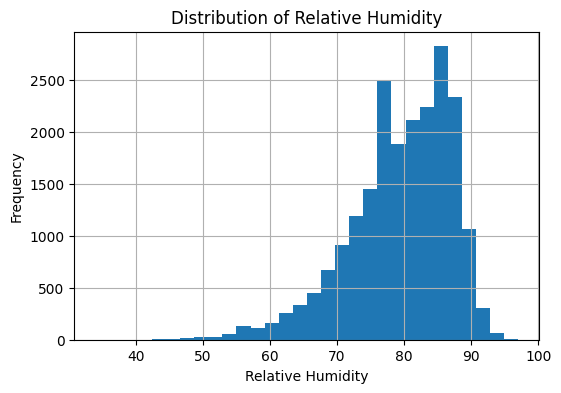

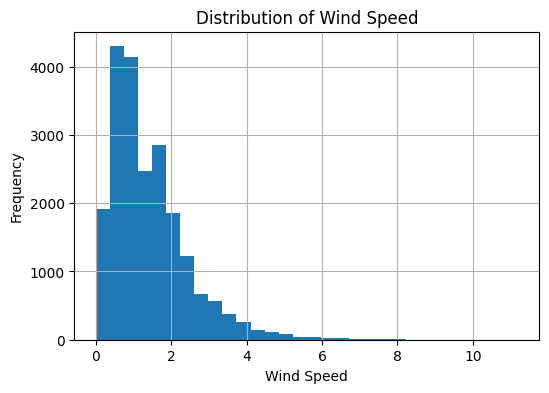

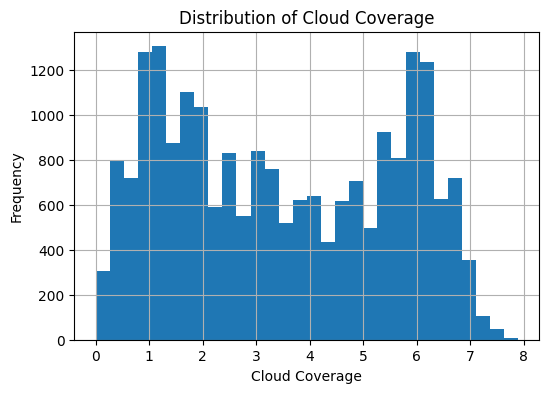

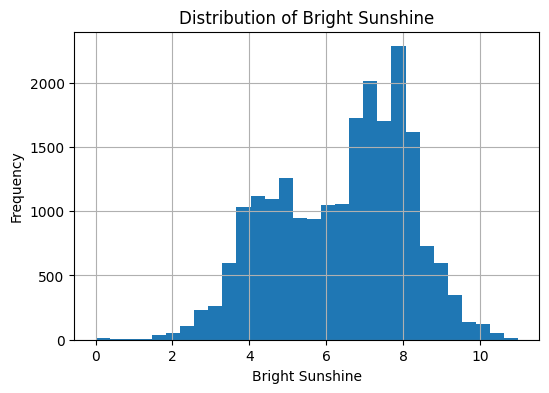

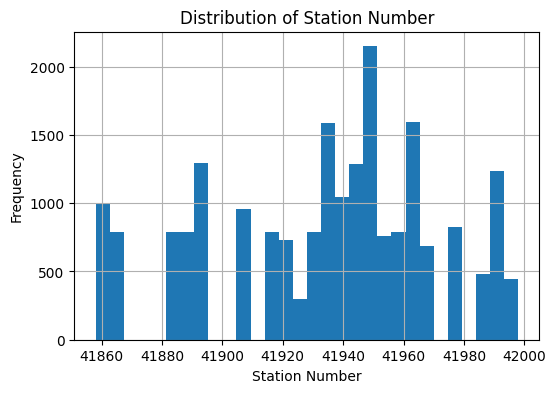

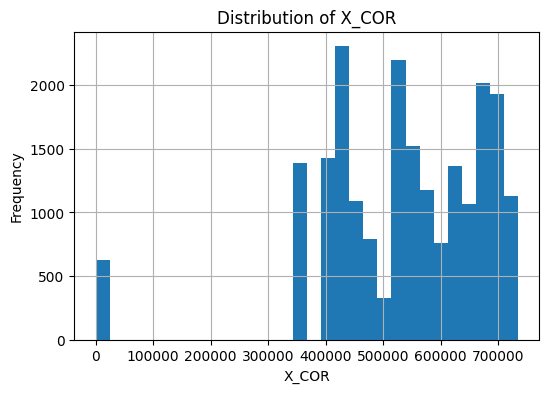

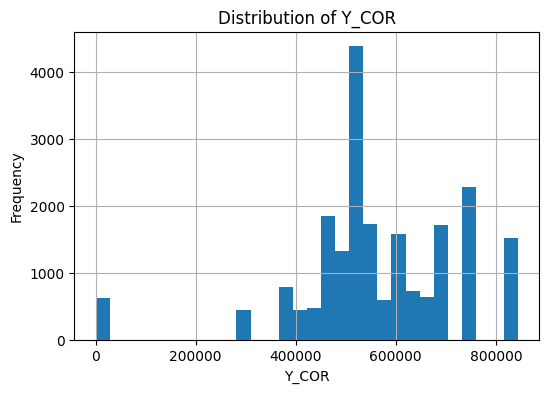

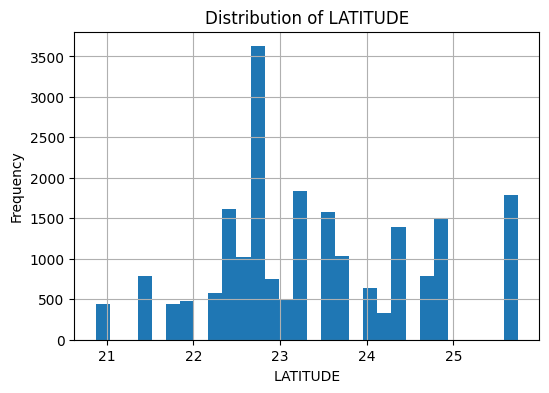

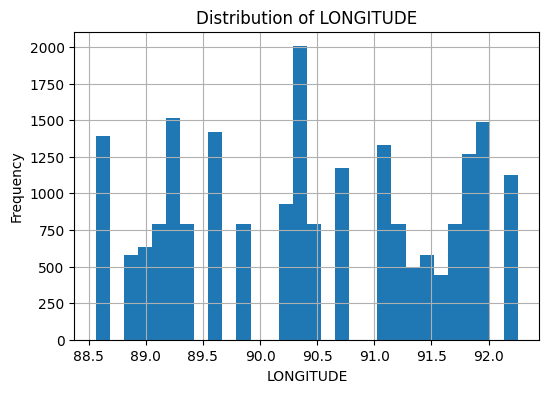

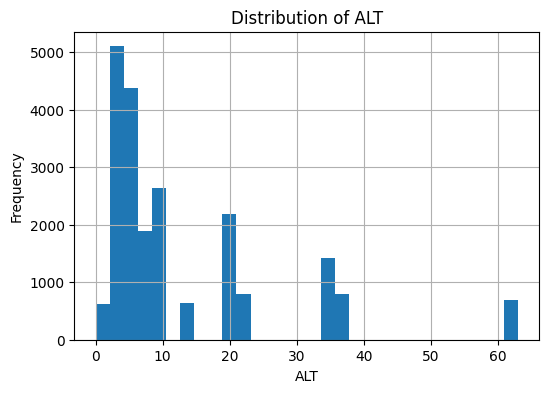

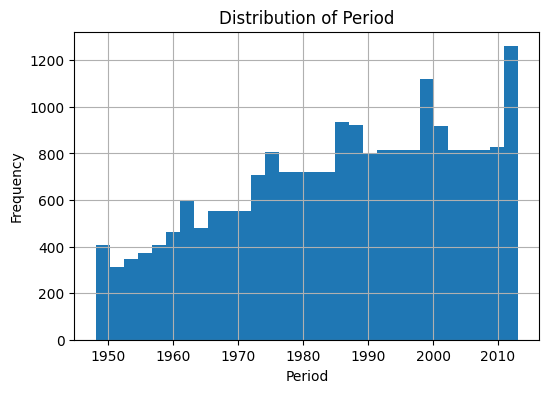

In [2]:
# Histroram
numerical_cols = df.select_dtypes(include=np.number).columns

for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    df[col].hist(bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

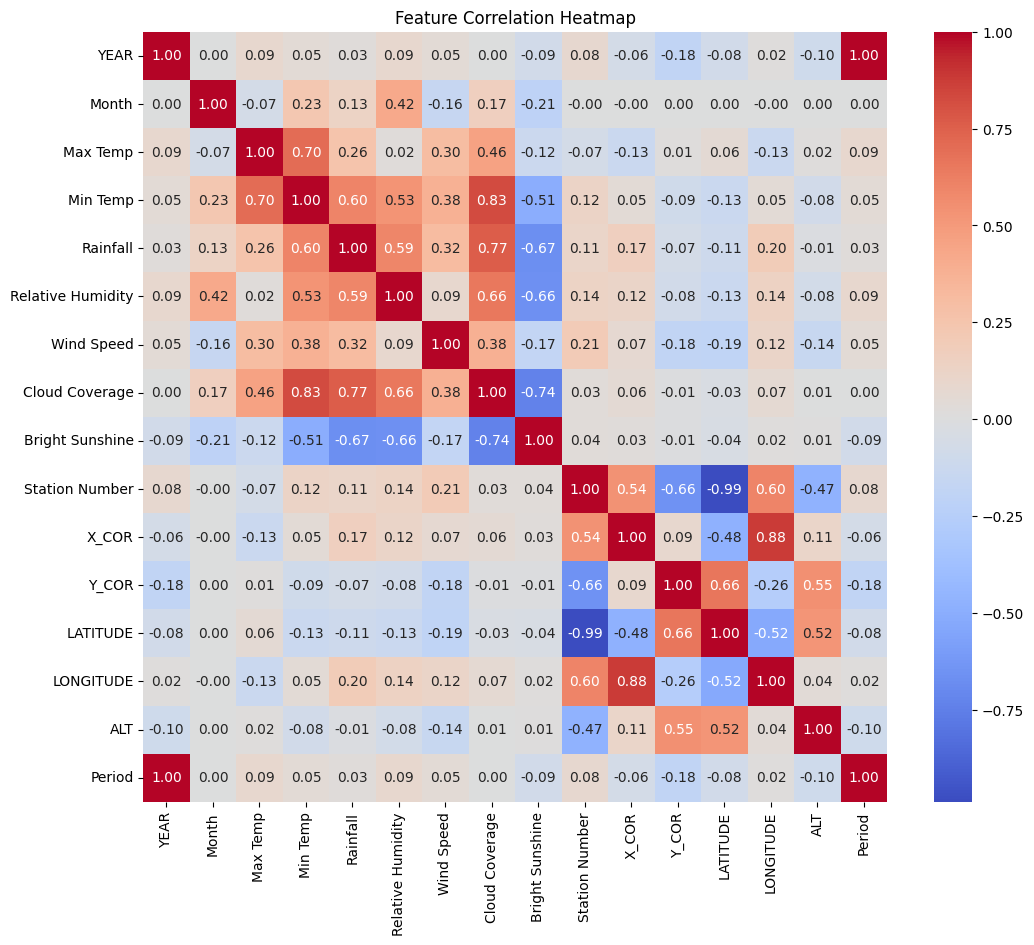

In [3]:
# Correlation Heatmap
plt.figure(figsize=(12, 10)) # Increased figure size for better readability
sns.heatmap(df.select_dtypes(include=np.number).corr(), cmap="coolwarm", annot=True, fmt=".2f") # Added annot=True and fmt=".2f"
plt.title("Feature Correlation Heatmap")
plt.show()

**Label Creation**

In [4]:
if 'flood' in df.columns:
    df['label'] = df['flood']
elif 'water_level' in df.columns:
    threshold = df['water_level'].quantile(0.9)
    df['label'] = (df['water_level'] >= threshold).astype(int)
else:
    rolling_rain = df['Rainfall'].rolling(3).sum()
    threshold = rolling_rain.quantile(0.95)
    df['label'] = (rolling_rain >= threshold).astype(int)

df = df.dropna()
print("\nLabel distribution:")
print(df['label'].value_counts())


Label distribution:
label
0    20062
1     1058
Name: count, dtype: int64


**Train-Test Split**

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

features = [c for c in df.columns if c not in ['label','date','station','lat','lon', 'Station Names']]
X = df[features]
y = df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=False
)

**Sequence Preparation**

In [6]:
LOOKBACK = 14

def make_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i])
        ys.append(y.iloc[i])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = make_sequences(X_train, y_train, LOOKBACK)
X_test_seq, y_test_seq = make_sequences(X_test, y_test, LOOKBACK)

print("Train sequence shape:", X_train_seq.shape)
print("Test sequence shape:", X_test_seq.shape)


Train sequence shape: (16882, 14, 16)
Test sequence shape: (4210, 14, 16)


**Deep Learning Models**

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    LSTM, Dense, Dropout, Conv1D,
    GlobalAveragePooling1D, BatchNormalization, Input
)
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import (
    confusion_matrix, roc_auc_score, roc_curve, auc,
    accuracy_score, classification_report
)

early_stop = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)

**Utility Functions**

In [8]:
def evaluate_model(model, X_test, y_test, X_train, y_train, name):
    # Train accuracy
    y_train_pred_prob = model.predict(X_train).ravel()
    y_train_pred = (y_train_pred_prob >= 0.5).astype(int)
    train_acc = accuracy_score(y_train, y_train_pred)

    # Test accuracy
    y_prob = model.predict(X_test).ravel()
    y_pred = (y_prob >= 0.5).astype(int)
    test_acc = accuracy_score(y_test, y_pred)

    auc_score = auc(*roc_curve(y_test, y_prob)[:2])

    print(f"\n {name} RESULTS ")
    print("Train Accuracy:", train_acc)
    print("Test Accuracy:", test_acc)
    print("AUC:", auc_score)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=["No Flood (0)","Flood (1)"]))


    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(name + " Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"AUC={auc_score:.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.legend()
    plt.title(name + " ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

    return test_acc, auc_score, y_prob

**LSTM Model**

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,801 (81.25 KB)

 Trainable params: 20,801 (81.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
950/950 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - AUC: 0.9149 - accuracy: 0.9484 - loss: 0.1324 - val_AUC: 0.8639 - val_accuracy: 0.6311 - val_loss: 0.6774
Epoch 2/30
950/950 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - AUC: 0.9845 - accuracy: 0.9787 - loss: 0.0516 - val_AUC: 0.8681 - val_accuracy: 0.6098 - val_loss: 0.8669
Epoch 3/30
950/950 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.9891 - accuracy: 0.9832 - loss: 0.0418 - val_AUC: 0.8680 - val_accuracy: 0.6122 - val_loss: 0.8785
Epoch 4/30
950/950 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - AUC: 0.9889 - accuracy: 0.9845 - loss: 0.0365 - val_AUC: 0.8575 - val_accuracy: 0.6092 - val_loss: 0.9632
Epoch 5/30
950/950 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.9948 - accuracy: 0.9845 - loss: 0.0353 - val_AUC: 0.8615 - val_accuracy: 0.6163 - val_loss: 0.9797
Epoch 6/30
950/950 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - AUC: 0.9932 - accuracy: 0.9832 - loss: 0.0372 - val_AUC: 0.8443 - val_accuracy: 0.6382 - val_loss: 0.9950
Epoch 7/30
950/950 ━━━━━━━━━━━━━━━━━━

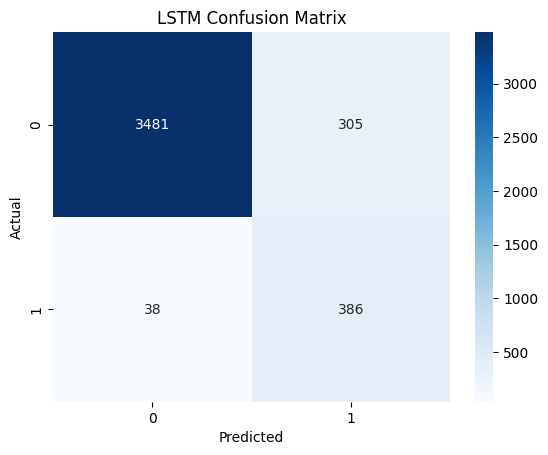

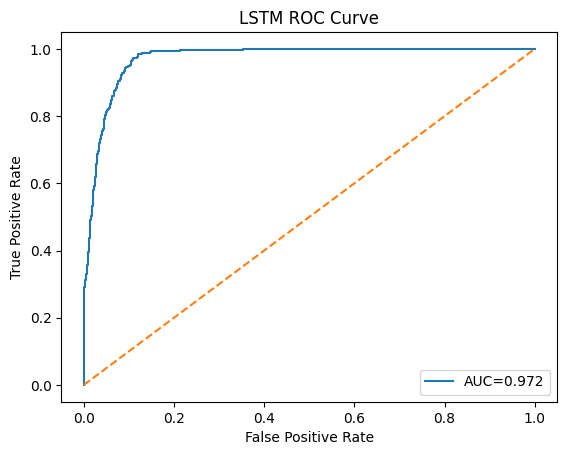

In [9]:
lstm = Sequential([
    LSTM(64, input_shape=(LOOKBACK, X_train_seq.shape[2])),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm.compile(optimizer='adam', loss='binary_crossentropy',
             metrics=['accuracy','AUC'])

lstm.summary()

hist_lstm = lstm.fit(
    X_train_seq, y_train_seq,
    validation_split=0.1,
    epochs=30,
    batch_size=16,
    callbacks=[early_stop]
)
acc_lstm, auc_lstm, prob_lstm = evaluate_model(
    lstm, X_test_seq, y_test_seq, X_train_seq, y_train_seq, "LSTM"
)

**CNN Model**

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 12, 64)         │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,857 (69.75 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/30
950/950 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - AUC: 0.9409 - accuracy: 0.9628 - loss: 0.1002 - val_AUC: 0.7874 - val_accuracy: 0.9047 - val_loss: 0.1771
Epoch 2/30
950/950 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9628 - accuracy: 0.9702 - loss: 0.0725 - val_AUC: 0.9031 - val_accuracy: 0.8567 - val_loss: 0.2075
Epoch 3/30
950/950 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9709 - accuracy: 0.9669 - loss: 0.0691 - val_AUC: 0.9245 - val_accuracy: 0.8988 - val_loss: 0.1346
Epoch 4/30
950/950 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9688 - accuracy: 0.9732 - loss: 0.0649 - val_AUC: 0.9169 - val_accuracy: 0.8686 - val_loss: 0.1623
Epoch 5/30
950/950 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9773 - accuracy: 0.9729 - loss: 0.0605 - val_AUC: 0.9391 - val_accuracy: 0.8958 - val_loss: 0.1360
Epoch 6/30
950/950 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9720 - accuracy: 0.9737 - loss: 0.0588 - val_AUC: 0.9016 - val_accuracy: 0.9728 - val_loss: 0.1098
Epoch 7/30
950/950 ━━━━━━━━━━━━━━━━━━━━

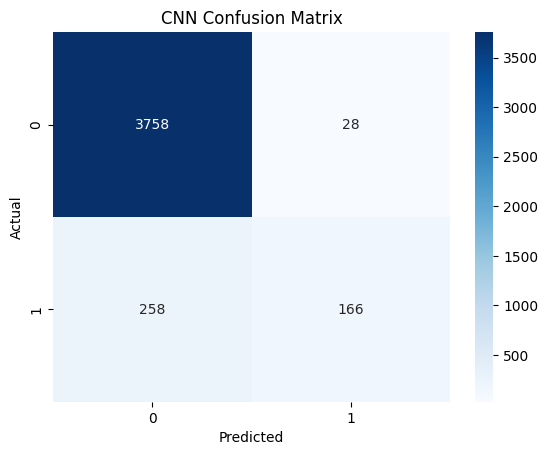

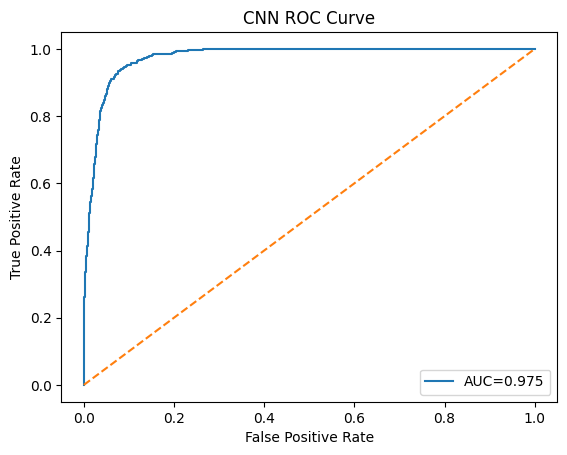

In [10]:
cnn = Sequential([
    Conv1D(64, 3, activation='relu',
           input_shape=(LOOKBACK, X_train_seq.shape[2])),
    BatchNormalization(),
    Conv1D(64, 3, activation='relu'),
    GlobalAveragePooling1D(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn.compile(optimizer='adam', loss='binary_crossentropy',
            metrics=['accuracy','AUC'])

cnn.summary()

hist_cnn = cnn.fit(
    X_train_seq, y_train_seq,
    validation_split=0.1,
    epochs=30,
    batch_size=16,
    callbacks=[early_stop]
)
acc_cnn, auc_cnn, prob_cnn = evaluate_model(
    cnn, X_test_seq, y_test_seq, X_train_seq, y_train_seq, "CNN"
)

**Hybrid CNN + LSTM Model**

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 14, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 12, 64)         │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 10, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,625 (197.75 KB)

 Trainable params: 50,625 (197.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
950/950 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - AUC: 0.9255 - accuracy: 0.9674 - loss: 0.1018 - val_AUC: 0.9493 - val_accuracy: 0.9414 - val_loss: 0.1075
Epoch 2/30
950/950 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - AUC: 0.9872 - accuracy: 0.9838 - loss: 0.0379 - val_AUC: 0.9546 - val_accuracy: 0.8946 - val_loss: 0.2186
Epoch 3/30
950/950 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.9945 - accuracy: 0.9848 - loss: 0.0352 - val_AUC: 0.9573 - val_accuracy: 0.9082 - val_loss: 0.1698
Epoch 4/30
950/950 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - AUC: 0.9943 - accuracy: 0.9855 - loss: 0.0348 - val_AUC: 0.9477 - val_accuracy: 0.8739 - val_loss: 0.3486
Epoch 5/30
950/950 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - AUC: 0.9925 - accuracy: 0.9853 - loss: 0.0356 - val_AUC: 0.9366 - val_accuracy: 0.8958 - val_loss: 0.2808
Epoch 6/30
950/950 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - AUC: 0.9883 - accuracy: 0.9863 - loss: 0.0342 - val_AUC: 0.9347 - val_accuracy: 0.8999 - val_loss: 0.2127
Epoch 7/30
950/950 ━━━━━━━━━━━━━━━━━━━

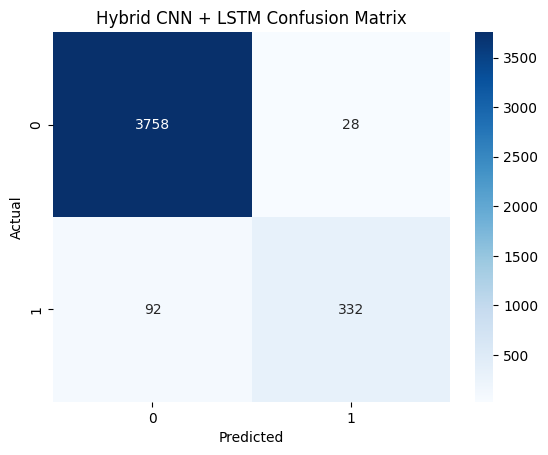

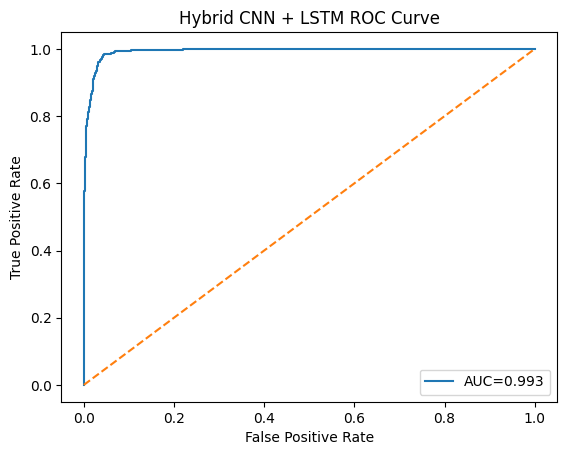

In [11]:
inp = Input(shape=(LOOKBACK, X_train_seq.shape[2]))
x = Conv1D(64, 3, activation='relu')(inp)
x = Conv1D(64, 3, activation='relu')(x)
x = LSTM(64)(x)
x = Dense(32, activation='relu')(x)
out = Dense(1, activation='sigmoid')(x)

hybrid = Model(inp, out)
hybrid.compile(optimizer='adam', loss='binary_crossentropy',
               metrics=['accuracy','AUC'])

hybrid.summary()

hist_hybrid = hybrid.fit(
    X_train_seq, y_train_seq,
    validation_split=0.1,
    epochs=30,
    batch_size=16,
    callbacks=[early_stop]
)
acc_hybrid, auc_hybrid, prob_hybrid = evaluate_model(
    hybrid, X_test_seq, y_test_seq, X_train_seq, y_train_seq, "Hybrid CNN + LSTM"
)

**Model Comparison**


 MODEL COMPARISON 
             Model  Accuracy       AUC
2  Hybrid CNN+LSTM  0.971496  0.993334
1              CNN  0.932067  0.975296
0             LSTM  0.918527  0.971858


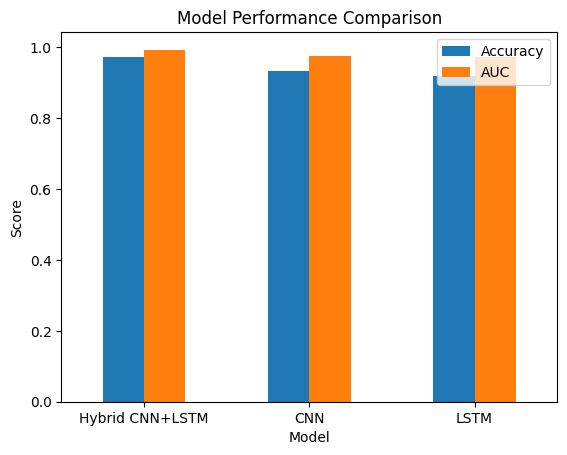

In [12]:
comparison = pd.DataFrame({
    "Model": ["LSTM", "CNN", "Hybrid CNN+LSTM"],
    "Accuracy": [acc_lstm, acc_cnn, acc_hybrid],
    "AUC": [auc_lstm, auc_cnn, auc_hybrid]
})

comparison = comparison.sort_values("AUC", ascending=False)
print("\n MODEL COMPARISON ")
print(comparison)

comparison.set_index("Model").plot(kind="bar")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.show()

**Save Best Model + test.csvn**

In [13]:
best_model_name = comparison.iloc[0]["Model"]
print("Best Model:", best_model_name)

if best_model_name == "LSTM":
    final_model, probs = lstm, prob_lstm
elif best_model_name == "CNN":
    final_model, probs = cnn, prob_cnn
else:
    final_model, probs = hybrid, prob_hybrid

preds = (probs >= 0.5).astype(int)

test_df = pd.DataFrame({
    "Actual": y_test_seq,
    "Predicted": preds,
    "Probability": probs
})

test_df.to_csv("test.csv", index=False)
final_model.save("best_flood_model.h5")

print("Saved: test.csv and best_flood_model.h5")

Best Model: Hybrid CNN+LSTM
Saved: test.csv and best_flood_model.h5


**Best model load**

In [14]:
from tensorflow.keras.models import load_model

model = load_model('/content/best_flood_model.h5')
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 14, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 12, 64)         │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 10, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,627 (197.77 KB)

 Trainable params: 50,625 (197.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)